Q1 Age Detection Dataset	50 MB, Age recognition, 3 classes: old, middle, young

In [6]:
import kagglehub

path = kagglehub.dataset_download("arashnic/faces-age-detection-dataset")

print("Path to dataset files:", path)

#načítame dataset s kagglehub

Path to dataset files: /Users/faustyn/.cache/kagglehub/datasets/arashnic/faces-age-detection-dataset/versions/2


In [7]:
import os
import pandas as pd

path = "/Users/faustyn/.cache/kagglehub/datasets/arashnic/faces-age-detection-dataset/versions/2/faces"
#do cesty je potrebné pridať svojho usera
csv_file = os.path.join(path, "train.csv")
csv = pd.read_csv(csv_file)
print("Result examples:")
print(csv.head())
#zapís do jedného súboru


Result examples:
          ID   Class
0    377.jpg  MIDDLE
1  17814.jpg   YOUNG
2  21283.jpg  MIDDLE
3  16496.jpg   YOUNG
4   4487.jpg  MIDDLE


Podľa formátu súboru vidíme, že máme dva stĺpce, kde jeden označuje obrázok a druhý označuje typ veku osoby

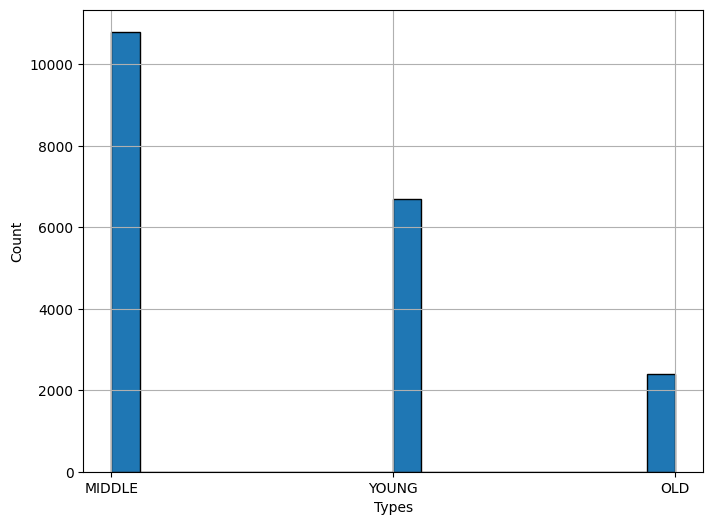

In [8]:
import matplotlib.pyplot as plt

csv["Class"].hist(bins=20, edgecolor='black', figsize=(8, 6))
plt.xlabel("Types")
plt.ylabel("Count")
plt.show()
#úkažka koľko máme s každého týpu v nášom datasete


Graf zobrazuje všetky typy vekových skupín v našom súbore údajov a ich počet a ako ich vidíme, najväčší počet pripadá na populáciu stredného veku, 
mladých ľudí je takmer o polovicu menej a starých ľudí je 1/4 populácie stredného veku

Na základe tohto počtu môžeme mať problém, že údaje na trénovanie nie sú presne a rovnomerne rozdelené, ale to ešte musíme dokázať a preukázať. 

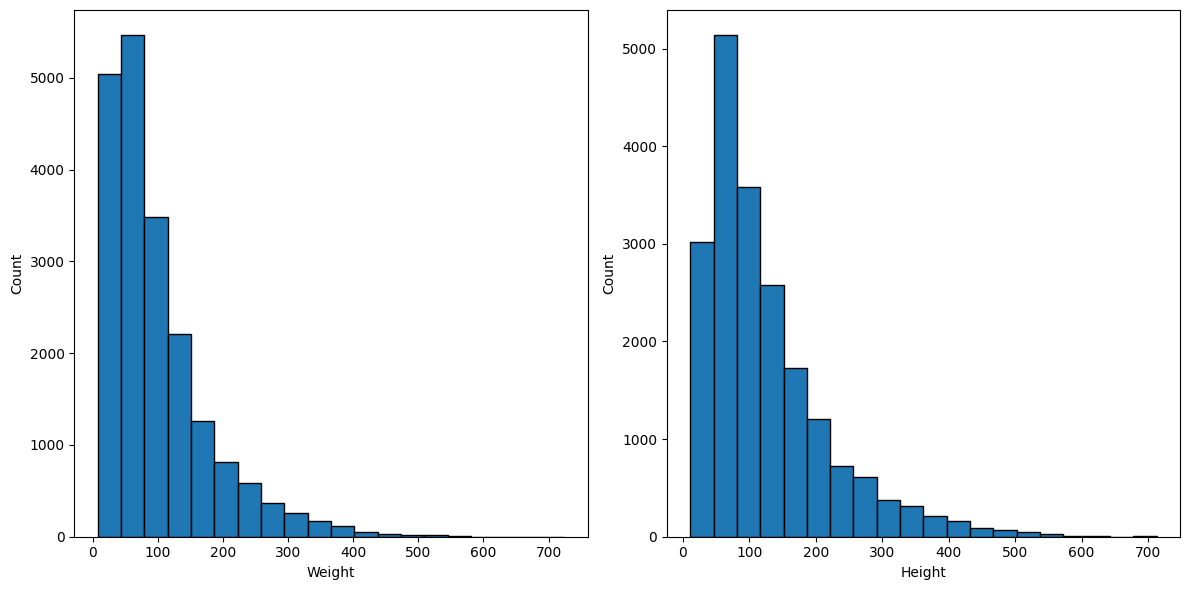

In [9]:
import os
from PIL import Image
import matplotlib.pyplot as plt

image_folder = "/Users/faustyn/.cache/kagglehub/datasets/arashnic/faces-age-detection-dataset/versions/2/faces/Train"
#do cesty je potrebné pridať svojho usera

widths = []
heights = []


# scan all imagess
for img_file in os.listdir(image_folder):
    if img_file.endswith((".jpg")):  # Проверяем формат
        img_path = os.path.join(image_folder, img_file)
        with Image.open(img_path) as img:
            widths.append(img.width)
            heights.append(img.height)
    else:
        print("Incorrect format of image")


plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.hist(widths, bins=20, edgecolor='black')
plt.xlabel("Weight")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
plt.hist(heights, bins=20, edgecolor='black')
plt.xlabel("Height")
plt.ylabel("Count")


plt.tight_layout()
plt.show()
#kontrola formatu obrazkov v datasete,na trening mali by byť rovnakého formatu,ale zistilo sa že to tak nie je,nížšie máme graf s šírkámi a výškami


Weight: Väčšina obrázkov má šírku od 50 do 200 pixelov
Height: Podobne má väčšina obrázkov výšku medzi 50 a 200 pixelmi
Pri výbere optimálnej veľkosti na kompresiu budeme brať do úvahy priemernú hodnotu aj potrebu znížiť stratu kvality počas spracovania

Optimálna veľkosť pre kompresiu:
128x128 pixelov

Keďže spadáme do rozsahu väčšiny obrázkov (50-200)
Vhodné pre modely hlbokého učenia (veľkosti sú násobkom 2).
Zachováva rovnováhu medzi veľkosťou obrázka a rýchlosťou spracovania

In [10]:
print("Nulls detected:")
print(csv.isnull().sum())
print()
print("Duplicates detected:", csv.duplicated().sum())

for column in csv.columns:
    print(f"{column}: {csv[column].nunique()} unique values")

Nulls detected:
ID       0
Class    0
dtype: int64

Duplicates detected: 0
ID: 19906 unique values
Class: 3 unique values


Duplikáty ne boli najdene

Počet jedinečných ID 19906 

**Data Preprocessing**

Konvertujeme všetky obrázky do formátu RGB a tiež do veľkosti 128x128 a retejtneme ich a na to všetko použijeme library albumentations

In [11]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from tqdm import tqdm
import os

# output priečínok
output_folder = os.path.join(path, "processed_images")
os.makedirs(output_folder, exist_ok=True)

# ten pipeline je potrebný na to aby rôznymi spôsobmi meniť,pozitívne to ovplyvňuje výsledky,lebo nn učí sa na rôznych datách 
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=15, p=0.5),
    A.Resize(128, 128),
    ToTensorV2()
])

for img_file in tqdm(os.listdir(image_folder)):
    if img_file.endswith(".jpg"):
        img_path = os.path.join(image_folder, img_file)
        image = cv2.imread(img_path)

        # kontrolujeme či sa náchadzá súbor v annotáciach
        if img_file not in csv["ID"].values:
            print(f"Image {img_file} is not in annotation, skipping...")
            continue

        # konvergujeme všetko do RGB 
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # aplikujeme transformácie
        augmented = transform(image=image)["image"]

        # konvertujeme tenzor do NumPy pre saving
        augmented_image = augmented.permute(1, 2, 0).cpu().numpy()

        # úchovame procesované obrazky
        output_path = os.path.join(output_folder, img_file)
        cv2.imwrite(output_path, cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR))


/Users/faustyn/Developer/STU_2324/IAU/IAU_Project/.venv/lib/python3.12/site-packages/albumentations/check_version.py:51: UserWarning: Error fetching version info <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1000)>
  data = fetch_version_info()
100%|██████████| 19906/19906 [00:13<00:00, 1502.14it/s]


Previdime triedy („MIDDLE“, „YOUNG“, „OLD“) na číselné hodnoty

In [12]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
csv["age_group_encoded"] = encoder.fit_transform(csv["Class"])

print("Unique values in Class:", csv["Class"].unique())
print("Coded values in age_group_encoded:", csv["age_group_encoded"].unique())

csv.to_csv("processed_train.csv", index=False)
#encode 

Unique values in Class: ['MIDDLE' 'YOUNG' 'OLD']
Coded values in age_group_encoded: [0 2 1]


rozdeľme naše data na testováciu,trénováciu a validation množíny

In [35]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(csv, test_size=0.2, random_state=1)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=1)  # na validáciu stáči 20 percent

train_data.to_csv("processed_train.csv", index=False)
val_data.to_csv("processed_val.csv", index=False)
test_data.to_csv("processed_test.csv", index=False)

print(f"Train : {len(train_data)}")
print(f"Valid: {len(val_data)}")
print(f"Test: {len(test_data)}")


Train : 11943
Valid: 3981
Test: 3982


Mame za vyber Hlboké učenie (Deep Learning)

Keďže dataset obsahuje ID obrázkov, DL je pravdepodobne najlepšou voľbou, pretože dokáže automaticky extrahovať črty z obrázkov a riešiť zložité problémy.

**Modeling and evaluation**

Po spracovaní obrázkov a ich rozdelení do tréningovej, validačnej a testovacej sady vytvorme načítavač údajov, ktorý bude čítať obrázky zo zložky output_folder a priraďovať ich k štítkom zo súboru processed_train.csv

In [36]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class AgeDataset(Dataset):
    def __init__(self, csv_file, image_folder, transform=None):
        self.data = pd.read_csv(csv_file)
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.data.iloc[idx, 0])  # Assuming 'Image ID' is in column 0
        image = Image.open(img_name).convert("RGB")
        label = self.data.iloc[idx, -1]  # Assuming 'age_group_encoded' is the last column

        if self.transform:
            image = self.transform(image)

        return image, label


DataLoader na načítanie údajov po batčach do modelu

In [37]:
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


train_dataset = AgeDataset(csv_file="processed_train.csv", image_folder=output_folder, transform=data_transforms)
val_dataset = AgeDataset(csv_file="processed_val.csv", image_folder=output_folder, transform=data_transforms)
test_dataset = AgeDataset(csv_file="processed_test.csv", image_folder=output_folder, transform=data_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Naš dataset obsahuje veľké množstvo obrázkov a preto použime Transfer Learning s CNN (ako ResNet50 / EfficientNet) a vyskušajme a ine modely

In [41]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.dropout = nn.Dropout(0.5)  # Dropout layer
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x.view(-1, 64 * 32 * 32))  # Flatten with Dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Dropout before final layer
        x = self.fc2(x)
        return x

model = SimpleCNN(num_classes=3)

import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



def train(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels)

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = correct.double() / len(loader.dataset)

    return epoch_loss, epoch_acc


def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels)

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = correct.double() / len(loader.dataset)

    return epoch_loss, epoch_acc


In [42]:
num_epochs = 10

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}")
    print(f"Val loss: {val_loss:.4f}, Val acc: {val_acc:.4f}")


test_loss, test_acc = validate(model, test_loader, criterion, device)
print(f"Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")


Epoch 1/10
Train loss: 0.9437, Train acc: 0.5716
Val loss: 0.8459, Val acc: 0.6149


KeyboardInterrupt: 

РЕЗУЛЬТАТЫ МОДЕЛИ В ЛОСЕ проверка на андер и овер фитинг 

In [64]:
#Model: Transfer Learning (ResNet50)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim
from torchvision.models import resnet50, ResNet50_Weights

import ssl
import urllib.request
import certifi

# Create SSL context with updated certificates
ssl_context = ssl.create_default_context(cafile=certifi.where())
url = "https://download.pytorch.org/models/resnet50-0676ba61.pth"
output_path = "resnet50-0676ba61.pth"  # Replace with your desired save path

# Use urlopen with SSL context
with urllib.request.urlopen(url, context=ssl_context) as response, open(output_path, 'wb') as out_file:
    out_file.write(response.read())

print("File downloaded successfully!")


class ResNet50TransferLearning(nn.Module):
    def __init__(self, num_classes):
        super(ResNet50TransferLearning, self).__init__()

        self.resnet50 = resnet50(weights=None)  # Initialize without weights

        
        state_dict = torch.load(output_path)
        self.resnet50.load_state_dict(state_dict)
        
        for param in self.resnet50.parameters():
            param.requires_grad = False
        
        in_features = self.resnet50.fc.in_features
        self.resnet50.fc = nn.Sequential(
            nn.Linear(in_features, in_features),  # projection layer
            nn.ReLU(),                            # activation
            nn.Dropout(p=dropout_rate),           # Dropout
            nn.Linear(in_features, num_classes)   # output layer
        )
        
    def forward(self, x):
        return self.resnet50(x)

# Model Parameters
num_classes = 3

# Initialize Model
model2 = ResNet50TransferLearning(num_classes=num_classes)

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = model2.to(device)

# Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.resnet50.fc.parameters(), lr=0.001)

# Training Function
def train(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels)

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = correct.double() / len(loader.dataset)

    return epoch_loss, epoch_acc

# Validation Function
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels)

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = correct.double() / len(loader.dataset)

    return epoch_loss, epoch_acc

File downloaded successfully!


/var/folders/5z/646fhd_x0vz_f_b50b5kmsgm0000gn/T/ipykernel_82230/3838296923.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(output_path)


In [65]:
num_epochs = 10
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}")
    print(f"Val loss: {val_loss:.4f}, Val acc: {val_acc:.4f}")

test_loss, test_acc = validate(model, test_loader, criterion, device)
print(f"Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")


Epoch 1/10
Train loss: 0.8048, Train acc: 0.6355
Val loss: 0.7878, Val acc: 0.6441


KeyboardInterrupt: 

РЕЗУЛЬТАТЫ МОДЕЛИ В ЛОСЕ

In [66]:
#Model: Random Forest
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss
import numpy as np

# Класс для использования Random Forest в стиле PyTorch
class RandomForestModel:
    def __init__(self, num_classes, n_estimators=100):
        self.num_classes = num_classes
        self.model = RandomForestClassifier(n_estimators=n_estimators)

    def fit(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)

    def predict_proba(self, X):
        return self.model.predict_proba(X)

# Предобработка данных для Random Forest
# Пример: преобразование тензоров PyTorch в numpy

def preprocess_loader(loader, device):
    X, y = [], []
    for images, labels in loader:
        images = images.to(device).view(images.size(0), -1).cpu().numpy()
        labels = labels.cpu().numpy()
        X.append(images)
        y.append(labels)
    return np.vstack(X), np.hstack(y)

# Инициализация модели Random Forest
num_classes = 3
rf_model = RandomForestModel(num_classes=num_classes)

# Устройство
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Функция обучения
def train_rf(model, loader, device):
    X_train, y_train = preprocess_loader(loader, device)
    model.fit(X_train, y_train)

# Функция валидации
def validate_rf(model, loader, device):
    X_val, y_val = preprocess_loader(loader, device)
    predictions = model.predict(X_val)
    probabilities = model.predict_proba(X_val)
    loss = log_loss(y_val, probabilities)
    acc = accuracy_score(y_val, predictions)
    return loss, acc

In [ ]:
num_epochs = 1  # Random Forest обучается за один "эпоху"
train_rf(rf_model, train_loader, device)

# Валидация модели
val_loss, val_acc = validate_rf(rf_model, val_loader, device)
print(f"Validation loss: {val_loss:.4f}, Validation acc: {val_acc:.4f}")

# Тестирование модели
test_loss, test_acc = validate_rf(rf_model, test_loader, device)
print(f"Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")

РЕЗУЛЬТАТЫ МОДЕЛИ В ЛОСЕ

In [ ]:
#Model: SVM
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, log_loss
import numpy as np

# Класс для использования SVM в стиле PyTorch
class SVMModel:
    def __init__(self, num_classes, kernel='linear', C=1.0):
        self.num_classes = num_classes
        self.model = SVC(kernel=kernel, C=C, probability=True)

    def fit(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)

    def predict_proba(self, X):
        return self.model.predict_proba(X)

# Предобработка данных для SVM
# Пример: преобразование тензоров PyTorch в numpy

def preprocess_loader(loader, device):
    X, y = [], []
    for images, labels in loader:
        images = images.to(device).view(images.size(0), -1).cpu().numpy()
        labels = labels.cpu().numpy()
        X.append(images)
        y.append(labels)
    return np.vstack(X), np.hstack(y)

# Инициализация модели SVM
num_classes = 3
svm_model = SVMModel(num_classes=num_classes, kernel='rbf', C=1.0)

# Устройство
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Функция обучения
def train_svm(model, loader, device):
    X_train, y_train = preprocess_loader(loader, device)
    model.fit(X_train, y_train)

# Функция валидации
def validate_svm(model, loader, device):
    X_val, y_val = preprocess_loader(loader, device)
    predictions = model.predict(X_val)
    probabilities = model.predict_proba(X_val)
    loss = log_loss(y_val, probabilities)
    acc = accuracy_score(y_val, predictions)
    return loss, acc


In [ ]:
# Обучение модели
num_epochs = 1  # SVM обучается за один "эпоху"
train_svm(svm_model, train_loader, device)

# Валидация модели
val_loss, val_acc = validate_svm(svm_model, val_loader, device)
print(f"Validation loss: {val_loss:.4f}, Validation acc: {val_acc:.4f}")

# Тестирование модели
test_loss, test_acc = validate_svm(svm_model, test_loader, device)
print(f"Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")


РЕЗУЛЬТАТЫ МОДЕЛИ В ЛОСЕ

**Porovnanie výkonnosti**

In [ ]:
#посчитать акураси и нет ли овер или андер фитинга

СРАВНЕНИЕ МОДЕЛЕЙ В АКУРАСИ

In [ ]:
Итоги и выбор лучшой модели и ее резултаты при трейн тесте акуранси и валидации